# Project Setup and Dependencies


In [ ]:
# Install necessary libraries
!pip install requests pandas numpy matplotlib seaborn scikit-learn tensorflow plotly kaleido folium statsmodels --quiet

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import folium
import json
from datetime import datetime, timedelta
import time # For potential API rate limiting

print("Libraries installed and imported.")

Libraries installed and imported.


# Configuration

In [ ]:
# Using Open-Meteo API (free, no key required for basic use)
# Reference: https://open-meteo.com/

# Coordinates for a specific location
LATITUDE = 24.4898
LONGITUDE = 86.699
LOCATION_NAME = "Deoghar, IN"

# Weather variables to fetch
# Options: temperature_2m, relativehumidity_2m, apparent_temperature, precipitation, rain, snowfall,
#          weathercode, surface_pressure, cloudcover, et0_fao_evapotranspiration, vapor_pressure_deficit,
#          windspeed_10m, winddirection_10m, windgusts_10m, soil_temperature_0_to_7cm, soil_moisture_0_to_7cm etc.
HOURLY_VARIABLES = ["temperature_2m", "precipitation", "relativehumidity_2m"]

# How many past days of data to fetch for analysis and training
PAST_DAYS = 90 # Fetch ~3 months of recent historical data

# --- Parameters for Models ---
N_STEPS_LSTM = 5  # Number of time steps to look back for LSTM prediction
N_FEATURES_LSTM = 1 # We will predict temperature based on past temperature

ANOMALY_CONTAMINATION = 0.02 # Expected proportion of outliers in the data for Isolation Forest

# Data Acquisition (Live API Call)

In [ ]:
def fetch_climate_data(latitude, longitude, past_days, hourly_vars):
    """Fetches historical weather data from Open-Meteo API."""
    print(f"Fetching data for coordinates: ({latitude}, {longitude})")
    BASE_URL = "https://archive-api.open-meteo.com/v1/archive" # Use archive API for recent past

    # Calculate date range
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=past_days)).strftime('%Y-%m-%d')

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(hourly_vars),
        "timezone": "auto" # Use local timezone of the coordinates
    }

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status() # Raise HTTPError for bad responses (4XX or 5XX)
        data = response.json()
        print("Data fetched successfully!")
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON response.")
        print("Response text:", response.text) # Print response if it's not valid JSON
        return None

# Fetch the data
raw_data = fetch_climate_data(LATITUDE, LONGITUDE, PAST_DAYS, HOURLY_VARIABLES)

# Process the data if fetched successfully
if raw_data:
    hourly_data = raw_data.get('hourly', {})
    df = pd.DataFrame(hourly_data)

    if 'time' not in df.columns or df.empty:
         print("Error: 'time' column not found in hourly data or data is empty.")
         print("Raw Data Structure:", raw_data) # Helps debug API response issues
         df = pd.DataFrame() # Set df to empty to avoid downstream errors
    else:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        print(f"\nDataframe created with shape: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nLast 5 rows:")
        print(df.tail())
        print("\nData Info:")
        df.info()
else:
    print("Could not proceed without data.")
    # Assign an empty dataframe to prevent errors in subsequent cells if execution continues
    df = pd.DataFrame()

Fetching data for coordinates: (24.4898, 86.699)
Data fetched successfully!

Dataframe created with shape: (2184, 3)

First 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2024-12-31 00:00:00            14.1            0.0                 82.0
2024-12-31 01:00:00            13.6            0.0                 85.0
2024-12-31 02:00:00            13.2            0.0                 89.0
2024-12-31 03:00:00            12.8            0.0                 93.0
2024-12-31 04:00:00            12.6            0.0                 95.0

Last 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2025-03-31 19:00:00             NaN            NaN                  NaN
2025-03-31 20:00:00             NaN            NaN                  NaN
2025-03-31 21:00:00             NaN            NaN            

# Data Preprocessing and Cleaning

In [ ]:
if not df.empty:
    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Simple imputation: Forward fill for time series data
    # More sophisticated methods could be used (interpolation, model-based imputation)
    df.ffill(inplace=True) # Forward fill handles missing sensor readings potentially
    df.bfill(inplace=True) # Back fill handles any remaining NaNs at the beginning

    print("\nMissing values after forward/backward fill:")
    print(df.isnull().sum())

    # Ensure numeric types (sometimes API might return strings if errors occur)
    for col in HOURLY_VARIABLES:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce converts errors to NaT/NaN

    # Re-check and drop rows if any NaNs persisted after coercion (shouldn't happen with ffill/bfill unless all data for a col was bad)
    df.dropna(inplace=True)

    print(f"\nDataframe shape after cleaning: {df.shape}")
    print("\nBasic Statistics:")
    print(df.describe())
else:
    print("Skipping preprocessing as DataFrame is empty.")


Missing values per column:
temperature_2m         42
precipitation          42
relativehumidity_2m    42
dtype: int64

Missing values after forward/backward fill:
temperature_2m         0
precipitation          0
relativehumidity_2m    0
dtype: int64

Dataframe shape after cleaning: (2184, 3)

Basic Statistics:
       temperature_2m  precipitation  relativehumidity_2m
count     2184.000000    2184.000000          2184.000000
mean        21.400137       0.007601            53.456502
std          6.155487       0.092340            23.255634
min          8.900000       0.000000             8.000000
25%         16.500000       0.000000            34.000000
50%         21.000000       0.000000            51.000000
75%         25.600000       0.000000            72.000000
max         37.400000       2.100000           100.000000


# Exploratory Data Analysis (EDA) & Visualization

In [ ]:
if not df.empty:
    print("\n--- Generating Visualizations ---")

    # Time Series Plots (Interactive with Plotly)
    print("\nPlotting Time Series...")
    fig_ts = go.Figure()

    for col in HOURLY_VARIABLES:
        fig_ts.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col))

    fig_ts.update_layout(
        title=f'Hourly Climate Variables for {LOCATION_NAME} (Last {PAST_DAYS} Days)',
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='Variable',
        hovermode="x unified" # Nice hover effect
    )
    fig_ts.show()

    # Distribution Plots (Histograms using Plotly Express)
    print("\nPlotting Distributions...")
    for col in HOURLY_VARIABLES:
      fig_hist = px.histogram(df, x=col, title=f'Distribution of {col}')
      fig_hist.show()

    # Location Map (using Folium)
    print("\nGenerating Location Map...")
    m = folium.Map(location=[LATITUDE, LONGITUDE], zoom_start=10)
    folium.Marker(
        [LATITUDE, LONGITUDE],
        popup=f"{LOCATION_NAME}\nLat: {LATITUDE}\nLon: {LONGITUDE}",
        tooltip=LOCATION_NAME
    ).add_to(m)
    display(m) # Display map in Colab output

else:
    print("Skipping Visualization as DataFrame is empty.")


--- Generating Visualizations ---

Plotting Time Series...



Plotting Distributions...



Generating Location Map...


# Climate Prediction Model (Short-Term Temperature Forecast - LSTM)


--- Building Short-Term Temperature Forecast Model (LSTM) ---
Training data shape: X=(1743, 5, 1), y=(1743, 1)
Testing data shape: X=(436, 5, 1), y=(436, 1)

Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Training complete.


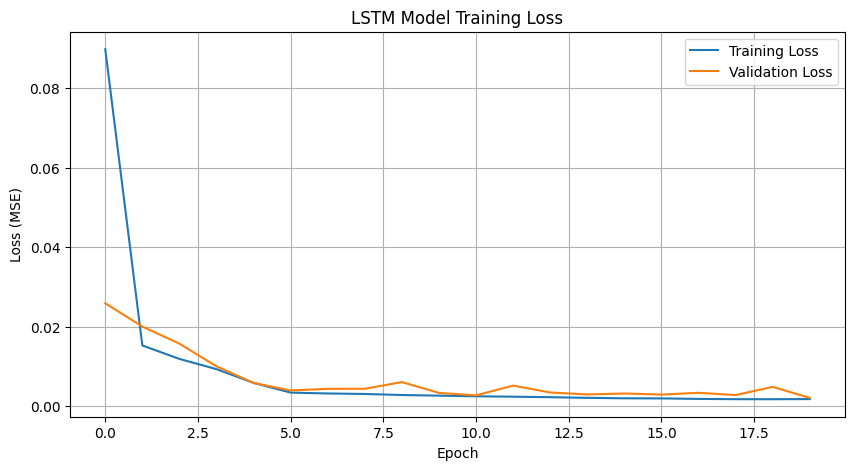

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Plotting Forecast vs Actual...



Mean Absolute Error (MAE) on Test Set: 0.97 °C
R-squared (R2) Score on Test Set: 0.93

Note: This is a simple short-term forecast based only on recent temperature history.
Real climate prediction requires much more data and complex models.


In [ ]:
if not df.empty and 'temperature_2m' in df.columns and len(df) > N_STEPS_LSTM * 2: # Ensure enough data for train/test split
    print("\n--- Building Short-Term Temperature Forecast Model (LSTM) ---")

    # Select Temperature data and scale it
    temp_data = df['temperature_2m'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(temp_data)

    # Create sequences for LSTM
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data)):
            end_ix = i + n_steps
            if end_ix > len(data)-1:
                break
            seq_x, seq_y = data[i:end_ix], data[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, N_STEPS_LSTM)

    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], N_FEATURES_LSTM))

    # Split data (using first 80% for training, rest for testing)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    time_index_test = df.index[N_STEPS_LSTM:][split_idx:] # Keep track of the timestamps for plotting test results

    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

    # Build the LSTM Model
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(N_STEPS_LSTM, N_FEATURES_LSTM)))
    # model_lstm.add(LSTM(50, activation='relu')) # Optional second layer
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse') # Mean Squared Error loss

    # Train the Model
    print("\nTraining LSTM model...")
    # Increase epochs for better performance, but keep low for demo speed
    history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0) # verbose=0 to keep output clean
    print("Training complete.")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Make Predictions
    y_pred_scaled = model_lstm.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled) # Inverse scale to get actual temperature values
    y_test_actual = scaler.inverse_transform(y_test) # Inverse scale the true values for comparison

    # Visualize Predictions vs Actual
    print("\nPlotting Forecast vs Actual...")
    fig_pred = go.Figure()
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_test_actual.flatten(), mode='lines', name='Actual Temperature'))
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_pred.flatten(), mode='lines', name='Predicted Temperature (LSTM)'))

    fig_pred.update_layout(
        title=f'Temperature Forecast vs Actual for {LOCATION_NAME} (Test Set)',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_pred.show()

    # Calculate some simple error metric
    # Mean Absolute Error
    mae = np.mean(np.abs(y_pred - y_test_actual))
    print(f"\nMean Absolute Error (MAE) on Test Set: {mae:.2f} °C")
    # R2 Score
    r2 = r2_score(y_test_actual, y_pred)
    print(f"R-squared (R2) Score on Test Set: {r2:.2f}")

    print("\nNote: This is a simple short-term forecast based only on recent temperature history.")
    print("Real climate prediction requires much more data and complex models.")

else:
     print("Skipping Prediction: DataFrame is empty, 'temperature_2m' column is missing, or not enough data points.")

# Anomaly Detection (using Isolation Forest)

In [ ]:
if not df.empty and 'temperature_2m' in df.columns:
    print("\n--- Performing Anomaly Detection on Temperature Data ---")

    # Using Isolation Forest - good for finding outliers
    model_iforest = IsolationForest(n_estimators=100, contamination=ANOMALY_CONTAMINATION, random_state=42)

    # Fit on the temperature data (or could use multiple features)
    temp_data_if = df[['temperature_2m']].copy() # Select data, ensure it's a DataFrame
    model_iforest.fit(temp_data_if)

    # Predict outliers: -1 for anomalies, 1 for inliers
    df['anomaly_temp'] = model_iforest.predict(temp_data_if)

    # Extract anomalies
    anomalies = df[df['anomaly_temp'] == -1]
    print(f"\nDetected {len(anomalies)} potential anomalies in temperature data.")

    # Visualize Anomalies
    print("\nPlotting Temperature with Detected Anomalies...")
    fig_anomaly = go.Figure()

    # Plot all temperature data
    fig_anomaly.add_trace(go.Scatter(
        x=df.index,
        y=df['temperature_2m'],
        mode='lines',
        name='Temperature (°C)'
    ))

    # Add markers for anomalies
    fig_anomaly.add_trace(go.Scatter(
        x=anomalies.index,
        y=anomalies['temperature_2m'],
        mode='markers',
        marker=dict(color='red', size=8, symbol='x'),
        name='Detected Anomaly'
    ))

    fig_anomaly.update_layout(
        title=f'Temperature Time Series with Anomaly Detection for {LOCATION_NAME}',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_anomaly.show()

    if not anomalies.empty:
      print("\nDetails of detected anomalies:")
      print(anomalies[['temperature_2m', 'anomaly_temp']])

else:
    print("Skipping Anomaly Detection: DataFrame is empty or 'temperature_2m' column is missing.")


--- Performing Anomaly Detection on Temperature Data ---

Detected 43 potential anomalies in temperature data.

Plotting Temperature with Detected Anomalies...



Details of detected anomalies:
                     temperature_2m  anomaly_temp
time                                             
2025-01-02 02:00:00             9.6            -1
2025-01-02 03:00:00             9.3            -1
2025-01-02 04:00:00             9.0            -1
2025-01-02 05:00:00             8.9            -1
2025-01-02 06:00:00             9.4            -1
2025-01-03 04:00:00             9.8            -1
2025-01-03 05:00:00             9.8            -1
2025-01-03 06:00:00             9.5            -1
2025-01-09 03:00:00             9.8            -1
2025-01-09 04:00:00             9.6            -1
2025-01-09 05:00:00             9.2            -1
2025-01-09 06:00:00             9.2            -1
2025-01-10 04:00:00             9.7            -1
2025-01-10 05:00:00             9.5            -1
2025-03-14 11:00:00            35.8            -1
2025-03-14 12:00:00            36.7            -1
2025-03-14 13:00:00            36.4            -1
2025-03-14 14:00:0

# Simple Dashboard / Summary Visualization

In [ ]:
# This section combines key plots into a simple overview.
# In a real application, this would use dashboarding tools like Dash/Streamlit, Power BI, Tableau.

if not df.empty:
    print("\n--- Summary Dashboard Components ---")

    # Re-displaying key plots generated above for a "dashboard-like" summary in Colab
    print("\n1. Time Series Overview:")
    if 'fig_ts' in locals(): # Check if plot was generated
      fig_ts.show()
    else:
      print("Time series plot not available.")


    print("\n2. Temperature Forecast (Test Set):")
    if 'fig_pred' in locals():
        fig_pred.show()
    else:
      print("Forecast plot not available.")

    print("\n3. Temperature Anomaly Detection:")
    if 'fig_anomaly' in locals():
        fig_anomaly.show()
    else:
      print("Anomaly plot not available.")


    print("\n4. Location Context:")
    if 'm' in locals():
      display(m)
    else:
      print("Map not available.")

else:
    print("Cannot generate summary dashboard components as DataFrame is empty.")


--- Summary Dashboard Components ---

1. Time Series Overview:



2. Temperature Forecast (Test Set):



3. Temperature Anomaly Detection:



4. Location Context:
